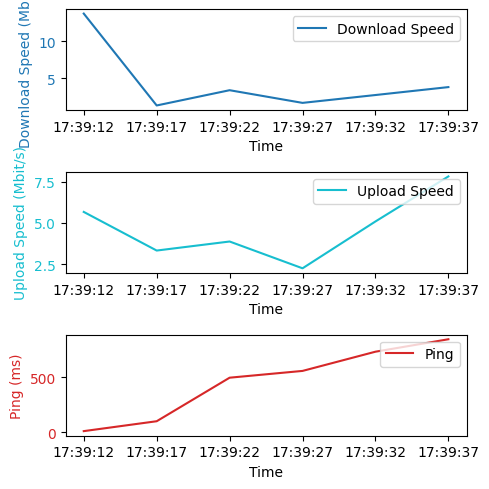

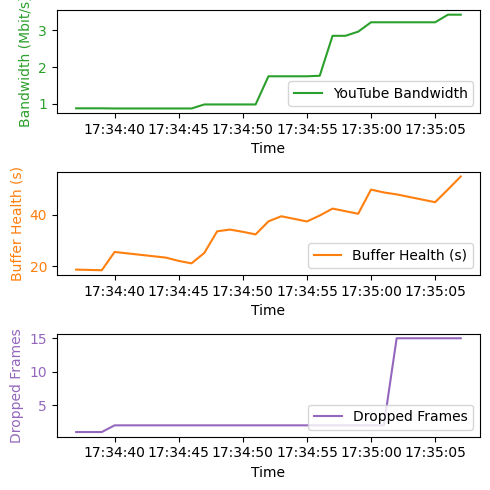

In [9]:
from posixpath import split
import json
import argparse
import matplotlib.pyplot as plt
import datetime
import re

# Extract individual speedtest result list.
def parse_speedtest_results(file_path):
    with open(file_path, 'r') as file:
        data = file.read()

    # Remove "<Success: defaultdict(<class 'list'>, {'bf55d766-3fdb-447c-9873-c7b7ab14d127': [<Success: ['" from the beginning of each block
    data = re.sub(r'<Success: defaultdict\(.*?\[<Success: \[\'', '', data)

    # Split text into individual blocks using "<Success:" as separator
    speedtest_blocks = data.split("<Success:")
    speedtest_results = []

    for block in speedtest_blocks:
        if not block.strip():
            continue

        # Extract data using regular expressions
        match = re.search(r'Ping: (\d+\.\d+) ms\\nDownload: (\d+\.\d+) Mbit/s\\nUpload: (\d+\.\d+) Mbit/s\\n\\n> Time taken: (\d+\.\d+) seconds Time started: (?P<TimeStarted>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', block)
        if match:
            ping, download, upload, time_taken, time_started = match.groups()
            timestamp = time_started.split(' ')[1]
            speedtest_results.append({
                'timestamp': timestamp,
                'ping': float(ping),
                'download': float(download),
                'upload': float(upload),
                'time_taken': float(time_taken)
            })

    return speedtest_results

# Parse YouTube QoE Stats for Nerds.
def parse_youtube_stats(file_path):
    youtube_stats = []
    with open(file_path, 'r') as file:
        for line in file:
            data = eval(line)
            timestamp = datetime.datetime.strptime(data['date'], '%a %b %d %Y %H:%M:%S GMT+0000 (Coordinated Universal Time)')
            bandwidth = float(data.get('bandwidth_kbps', '0').split()[0]) / 1000 # Convery since speedtest is in mbps.
            buffer_health = float(data.get('buffer_health_seconds', '0').split()[0])
            dropped_frames = int(data.get('dims_and_frames', '0').split()[2])
            network_activity = float(data.get('network_activity_bytes', '0').split()[0])  # Extract network activity bytes
            youtube_stats.append({
                'timestamp': timestamp,
                'bandwidth_mbps': bandwidth,
                'buffer_health_seconds': buffer_health,
                'dropped_frames': dropped_frames,
                'network_activity_bytes': network_activity
            })

    return youtube_stats

# Parse YouTube QoE Events (quality/ video changes).
def parse_youtube_events(file_path):
    youtube_events = []
    with open(file_path, 'r') as file:
        for line in file:
            data = eval(line)
            youtube_events.append({
                'video_id_and_cpn': data['video_id_and_cpn'],
                'fraction': data.get('fraction', None),
                'current_time': data.get('current_time', None),
                'new_quality': data.get('new_quality', None),
                'new_state': data.get('new_state', None)
            })
    return youtube_events

# Visualize results.
def plot_results(speedtest_results, youtube_stats, youtube_events):
    # Plot Speedtest Results
    fig, axs = plt.subplots(3, figsize=(5, 5))

    times = []
    count = 0
    for res in speedtest_results:
      if count % 5 ==0:
        times.append(res['timestamp'])
      count += 1
    download_speeds = []
    count1 = 0
    for res in speedtest_results:
      if count1 % 5 ==0:
        download_speeds.append(res['download'])
      count1 += 1

    upload_speeds = []
    count2 = 0
    for res in speedtest_results:
      if count2 % 5 ==0:
        upload_speeds.append(res['upload'])
      count2 += 1
    pings = []
    count3 = 0
    for res in speedtest_results:
      if count3 % 5 ==0:
        pings.append(res['ping'])
      count3 += 1

    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Download Speed (Mbit/s)', color='tab:blue')
    axs[0].plot(times, download_speeds, label='Download Speed', color='tab:blue')
    axs[0].tick_params(axis='y', labelcolor='tab:blue')

    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Upload Speed (Mbit/s)', color='tab:cyan')
    axs[1].plot(times, upload_speeds, label='Upload Speed', color='tab:cyan')
    axs[1].tick_params(axis='y', labelcolor='tab:cyan')

    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Ping (ms)', color='tab:red')
    axs[2].plot(times, pings, label='Ping', color='tab:red')
    axs[2].tick_params(axis='y', labelcolor='tab:red')

    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    axs[2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Plot YouTube Stats for Nerds
    fig, axs = plt.subplots(3, figsize=(5, 5))

    youtube_times = [stat['timestamp'] for stat in youtube_stats]
    bandwidths = [stat['bandwidth_mbps'] for stat in youtube_stats]  # Convert Kbps to Mbps
    buffer_healths = [stat['buffer_health_seconds'] for stat in youtube_stats]
    dropped_frames = [stat['dropped_frames'] for stat in youtube_stats]

    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Bandwidth (Mbit/s)', color='tab:green')
    axs[0].plot(youtube_times, bandwidths, label='YouTube Bandwidth', color='tab:green')
    axs[0].tick_params(axis='y', labelcolor='tab:green')

    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Buffer Health (s)', color='tab:orange')
    axs[1].plot(youtube_times, buffer_healths, label='Buffer Health (s)', color='tab:orange')
    axs[1].tick_params(axis='y', labelcolor='tab:orange')

    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Dropped Frames', color='tab:purple')
    axs[2].plot(youtube_times, dropped_frames, label='Dropped Frames', color='tab:purple')
    axs[2].tick_params(axis='y', labelcolor='tab:purple')

    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    axs[2].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # # Plot YouTube Events
    # fig, ax = plt.subplots(figsize=(5, 5))
    # # Plot vertical lines for each event
    # for event in youtube_events:
    #     event_time = event['current_time']
    #     if event.get('new_quality'):

    #         ax.axvline(event_time, color='gray', linestyle='--', label=f"Quality change: {event['new_quality']}")
    #     if event.get('new_state') is not None:
    #         ax.axvline(event_time, color='black', linestyle='--', label=f"State change: {event['new_state']}")

    # # Add legend and show plot
    # ax.legend(loc='upper left')
    # plt.show()

def main():

    # File paths for uploaded files.
    speedtest_file = '/content/speedtest_5000.txt'
    youtube_stats_file = '/content/report_5000.txt'
    youtube_events_file = '/content/event_r0u5URS3VXE_RGPW_TCD5_SFB2_9MRQ_CBT0_trial2.txt'

    # Parse files.
    speedtest_results = parse_speedtest_results(speedtest_file)
    youtube_stats = parse_youtube_stats(youtube_stats_file)
    youtube_events = parse_youtube_events(youtube_events_file)

    # Plot the results.
    plot_results(speedtest_results, youtube_stats, youtube_events)

    # parser = argparse.ArgumentParser(description="Plot network performance from speedtest results and YouTube QoE stats.")
    # parser.add_argument('speedtest_file', help='Path to the file containing speedtest results.')
    # parser.add_argument('youtube_stats_file', help='Path to the file containing YouTube QoE Stats for Nerds data.')
    # parser.add_argument('youtube_events_file', help='Path to the file containing YouTube session event data.')

    # args = parser.parse_args()

    # # Parse files
    # speedtest_results = parse_speedtest_results(args.speedtest_file)
    # youtube_stats = parse_youtube_stats(args.youtube_stats_file)
    # youtube_events = parse_youtube_events(args.youtube_events_file)

    # # Plot the results
    # plot_results(speedtest_results, youtube_stats, youtube_events)

if __name__ == "__main__":
    main()
